In [1]:
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

gpu_on = False

if gpu_on :
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
from gan_module.data_loader.segmentation import SegDataloader
from glob import glob

dataset_name = "vessel_level_1_512_random_org"
batch_size = 32

BACKBONE = 'resnet34'

train_image_path_list = glob(
    f"./datasets/{dataset_name}/[1-9]*/image*/*.png")
train_mask_path_list = glob(
    f"./datasets/{dataset_name}/[1-9]*/mask*/*.png")
valid_image_path_list = glob(
    f"./datasets/{dataset_name}/slide*/image*/*.png")
valid_mask_path_list = glob(
    f"./datasets/{dataset_name}/slide*/mask*/*.png")


train_data_loader = SegDataloader(
            image_path_list=train_image_path_list,
            mask_path_list=train_mask_path_list,
            batch_size=4,
            shuffle=True,
            backbone=BACKBONE,
        )
valid_data_loader = SegDataloader(
            image_path_list=valid_image_path_list,
            mask_path_list=valid_mask_path_list,
            batch_size=4,
            shuffle=True,
            backbone=BACKBONE,
        )

In [8]:
from tensorflow.keras.applications import InceptionV3, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.activations import sigmoid
import segmentation_models as sm

image_data_shape = train_data_loader.image_data_shape
mask_data_shape = train_data_loader.mask_data_shape

loss_function = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
model = sm.Unet(backbone_name=BACKBONE, input_shape=(
            None, None, image_data_shape[-1]), classes=mask_data_shape[-1], activation='sigmoid')

# Define Method

In [9]:
from tensorflow import keras
import matplotlib.cm as cm

BASE_DTYPE = "float32"

def get_last_conv_name(model):
    layer_names = [layer.name for layer in model.layers]
    conv_layer_name = [layer_name for layer_name in layer_names if layer_name.find("conv") >= 0]
    last_conv_name = conv_layer_name[-1]
    
    return last_conv_name

def get_img_array(img_path, size, dtype=BASE_DTYPE):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img, dtype=dtype)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image.open(cam_path))


def decode_classify_predictions(pred_array, index_to_label_dict):
    predicted_index = np.sum(np.argmax(preds, axis=1))
    predicted = index_to_label_dict[predicted_index]
    
    return predicted

In [10]:
layer_names = [layer.name for layer in model.layers]
conv_layer_name = [layer_name for layer_name in layer_names if layer_name.find("conv") >= 0]
last_conv_name = conv_layer_name[-1]

print(last_conv_name)

final_conv


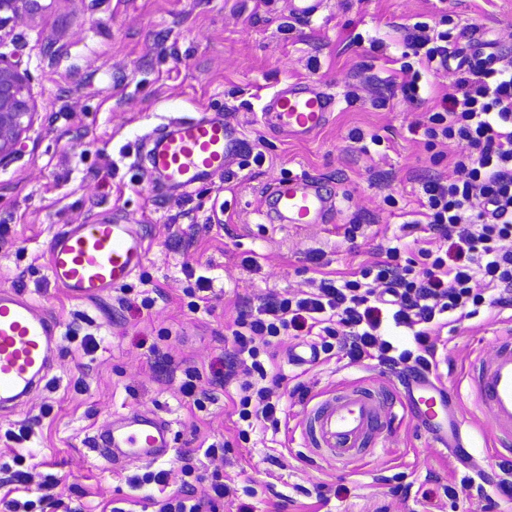

In [13]:
from PIL import Image

img_index = 2731

img_size = (512,512)
test_image_path = train_image_path_list[img_index]

display(Image.open(test_image_path))

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [17]:
test_model = model
model.load_weights("./U_net/weights_151_0.0028.hdf5")

In [21]:
from matplotlib import pyplot as plt

# Prepare image
img_array = get_img_array(test_image_path, size=img_size)
img_array_normalized = (img_array / 127.5) - 1
print(model.predict(img_array_normalized))
# Make model
test_model = model
test_model.load_weights("./U_net/weights_151_0.0028.hdf5")
# Remove last layer's softmax
print(model.predict(img_array_normalized))

# Print what the top predicted class is
preds = model.predict(img_array_normalized)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

[[[[5.9595704e-04]
   [5.2826686e-06]
   [6.9542057e-07]
   ...
   [5.6441957e-10]
   [1.2733744e-08]
   [1.7880942e-05]]

  [[4.7912499e-06]
   [1.9827935e-09]
   [1.0497361e-10]
   ...
   [4.1660312e-15]
   [2.0081602e-13]
   [1.5649812e-08]]

  [[1.3976276e-07]
   [1.1419968e-11]
   [2.3193537e-13]
   ...
   [2.3006471e-16]
   [4.5479088e-15]
   [7.4267437e-10]]

  ...

  [[1.3306152e-10]
   [4.1507844e-16]
   [6.4154077e-17]
   ...
   [2.5842251e-28]
   [4.8780551e-24]
   [4.0662198e-15]]

  [[3.7195818e-09]
   [2.6080117e-14]
   [1.0749531e-15]
   ...
   [8.2286925e-24]
   [4.8342726e-20]
   [1.4385418e-12]]

  [[6.8840141e-06]
   [3.5250027e-09]
   [2.6364202e-10]
   ...
   [8.6353865e-15]
   [2.0869625e-12]
   [6.9834577e-08]]]]
[[[[5.9595704e-04]
   [5.2826686e-06]
   [6.9542057e-07]
   ...
   [5.6441957e-10]
   [1.2733744e-08]
   [1.7880942e-05]]

  [[4.7912499e-06]
   [1.9827935e-09]
   [1.0497361e-10]
   ...
   [4.1660312e-15]
   [2.0081602e-13]
   [1.5649812e-08]]

  [[1.39

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [] != values[1].shape = [512,1] [Op:Pack]

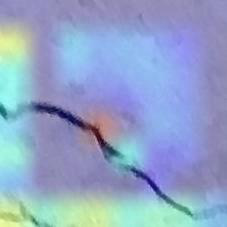

In [21]:
save_and_display_gradcam(test_image_path, heatmap)

In [24]:
last_conv_layer_name = last_conv_name
pred_index = None
# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
grad_model = keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [] != values[1].shape = [512,1] [Op:Pack]